# Rule-based control of a solar home

Pierre Haessig, April 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Load testcase data

In [136]:
E_rated = 10 # kWh
P_pvp = 3 # kW
P_grid_max = 3 # kW

In [137]:
df = pd.read_csv('../../data/data_2011-2012.csv', index_col=0, parse_dates=True)

# slice test weeks
df = df['2011-11-29':'2011-12-05'] # 1 week
#df = df['2011-11-29':'2011-12-12'] # 2 weeks
#df = df['2011-11-29':'2011-12-19'] # 3 weeks

n = len(df)
n

336

In [138]:
P_load = df.GC
P_sun = df.GG/1.04*P_pvp;

dt = 0.5 # hours
t = np.arange(n)*dt # hours
td = t/24 #days

In [139]:
print('Average sun energy: {:.2f} kWh/d'.format(P_sun.mean()*24))
print('Average load      : {:.2f} kWh/d'.format(P_load.mean()*24))
print('ratio sun/load: {:.2%}'.format(P_sun.mean()/P_load.mean()))

Average sun energy: 12.71 kWh/d
Average load      : 16.90 kWh/d
ratio sun/load: 75.22%


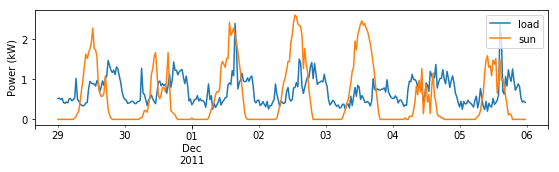

In [140]:
fig = plt.figure(figsize=(8,2.5))
P_load.plot(label='load')
P_sun.plot(label='sun')
plt.legend()
plt.ylabel('Power (kW)')
fig.tight_layout()

## Rule based control

control rules:

* storage should follow the net load as much as possible: $P_{sto} = -P_{nl} = P_{sun} - P_{load} $
* if empty, use grid instead
* if full, curtail the excess of production

inputs: $P_{sun}$, $P_{load}$ and storage state $E_{sto}$

Outputs: $P_{sto}$, $P_{grid}$, $P_{curt}$

def: net load: $P_{nl} = P_{load} - P_{sun}$

* if $P_{nl}>0$ (load > sun)
  * if battery not empty: battery discharge to follow net load $P_{sto} = -P_{nl} <0 $, $P_{grid} = 0$.
  * if battery is empty, use the grid instead: $P_{grid} = P_{nl}$
* if $P_{nl}<0$ (sun > load)
  * if battery not full: battery charges to absorbe net production $P_{sto} = -P_{nl} > 0$, $P_{grid} = 0$.
  * if battery is full, curtail the excess of production: $P_{curt} = -P_{nl}$, so that $P_{sun} - P_{curt} = P_{pv} = P_{load}$. $P_{grid} = 0$

In [141]:
def control(P_sun, P_load, E_sto):
    P_nl = P_load - P_sun
    # outputs:
    P_sto = 0
    P_grid = 0
    P_curt = 0
    
    E_next = E_sto - P_nl*dt
    
    if P_nl>0: # (load > sun)
        E_next = E_next if E_next>0. else 0.
        P_sto = (E_next - E_sto)/dt # <0
        P_grid = P_nl + P_sto
    else:
        E_next = E_next if E_next<E_rated else E_rated
        P_sto = (E_next - E_sto)/dt # >0
        P_curt = -P_nl - P_sto
    return P_sto, P_grid, P_curt

In [142]:
control(1,3, 5)

(-2.0, 0.0, 0)

In [143]:
control(1,3, 0)

(0.0, 2.0, 0)

In [144]:
control(1,3, 0.1*dt)

(-0.1, 1.9, 0)

In [145]:
control(3,1, 5)

(2.0, 0, 0.0)

In [146]:
control(3,1, E_rated)

(0.0, 0, 2.0)

In [147]:
control(3,1, E_rated-0.1*dt)

(0.10000000000000142, 0, 1.8999999999999986)

In [148]:
P_sto = np.zeros(n)
E_sto = np.zeros(n+1)
P_grid = np.zeros(n)
P_curt = np.zeros(n)

E_sto[0]= E_rated/2

for k in range(n):
    P_sto[k], P_grid[k], P_curt[k] = control(P_sun[k], P_load[k], E_sto[k])
    E_sto[k+1] = E_sto[k] + P_sto[k]*dt
    assert 0 <= E_sto[k+1] <= E_rated

    
E_sto = E_sto[:-1]
P_pv = P_sun - P_curt
P_nl = P_load - P_sun

In [149]:
print('E_load: {:6.2f} kWh/d (data)'.format(P_load.mean()*24))
print('E_sun:  {:6.2f} kWh/d (data)'.format(P_sun.mean()*24))
print('E_pv:   {:6.2f} kWh/d'.format(P_pv.mean()*24))
print('E_curt: {:6.2f} kWh/d'.format(P_curt.mean()*24))
print('E_grid: {:6.2f} kWh/d'.format(P_grid.mean()*24))

E_load:  16.90 kWh/d (data)
E_sun:   12.71 kWh/d (data)
E_pv:    12.40 kWh/d
E_curt:   0.31 kWh/d
E_grid:   3.78 kWh/d


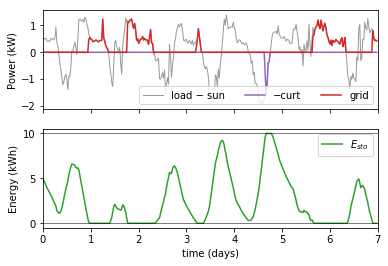

In [150]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(td, P_nl, label='load − sun',
           color=(0.6,)*3, lw=1)

ax[0].plot(td, -P_curt, label='−curt',
           color='tab:purple')

ax[0].plot(td, P_grid, label='grid',
           color='tab:red')

ax[0].legend(ncol=4)
ax[0].set(
    ylabel='Power (kW)'
)

ax[1].plot(td, E_sto, label='$E_{sto}$',
           color='tab:green');
ax[1].axhline(0, color='k', lw=0.5)
ax[1].axhline(E_rated, color='k', lw=0.5)

ax[1].legend()
ax[1].set(
    xlabel='time (days)',
    ylabel='Energy (kWh)',
    ylim=(-.05*E_rated, 1.05*E_rated),
    xlim=(0, n//48)
);

### Write results

julia:

```
function write_results(fname, res)
    f = open(fname, "w")
    # header
    write(f, ",P_grid,P_curt,P_sto,E_sto\n")
    # optimization data
    data = zip(
        date, 
        res["P_grid"],
        res["P_curt"],
        res["P_sto"],
        res["E"][1:end-1])
    writecsv(f, data)
    close(f)
end

write_results("results/anticipative.csv", res_anticip)
write_results("results/fixed.csv", res_fixed)
```

In [ ]:
# TODO

## Sensitivity analysis against sizing

for a given load, effect of:

* P_pv rated
* E_rated